## Setup

In [1]:
import os
import sys

import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        #for i in range(min(1, num_months_lag + 1), max(1, num_months_lag+1)):
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [3]:
# A helper function to format RAPID in the same way as the other output streamfunctions for training
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(RAPID_path)

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [4]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    return PSI.isel(k=max_index)

In [5]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment variables

In [153]:
data_home = paths.LOCAL_DIR

# We are specifically interested in the atlantic mask at 30S 
lat = -30
atlantic_lon_min = -50
atlantic_lon_max = 17

ECCO_GRID = xr.open_dataset(paths.geom_fp)

RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")
strf_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"
depth_path = f"{data_home}/ecco_data_minimal/depth_range.pickle"

## Loading and preprocessing relevant data

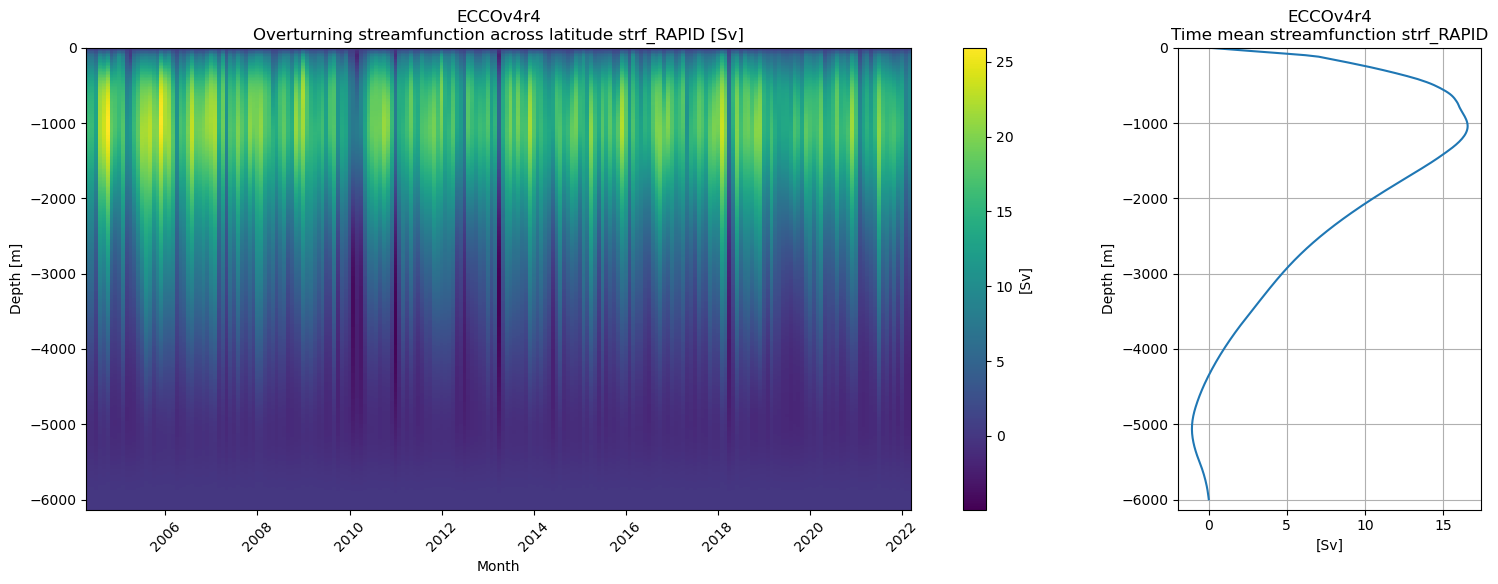

In [200]:
# Prepare the input RAPID streamfunction and resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')
RAPID_all_inputs = add_lags_inputs(RAPID_inputs, np.arange(48))    

plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

In [223]:
# Prepare the input surface variables at 30S and clip them according to the atlantic basin mask
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(atlantic_lon_min, atlantic_lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

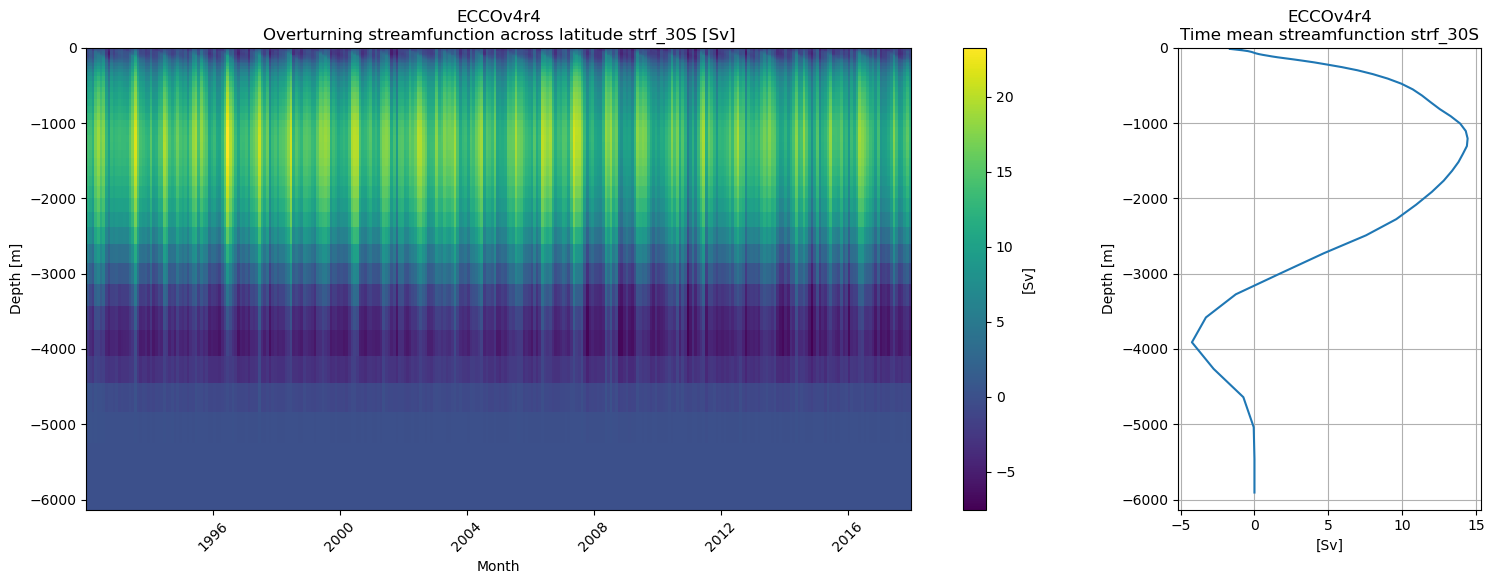

In [224]:
# Retrieve the output 30S streamfunction and calculate the moc strenght in the upper and lower cell
with open(strf_path, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1]  #Invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1)  # grabbing just 30S
strf = np.transpose(strf, (2, 0, 1))

strf = xr.Dataset(
    data_vars={'moc': (["time", "k", "latitude"], strf)},
    coords={'time': inputs.time, 'k': np.arange(50), 'latitude': np.atleast_1d(-60)}
)
ECCO_GRID = xr.open_dataset(paths.geom_fp)
strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

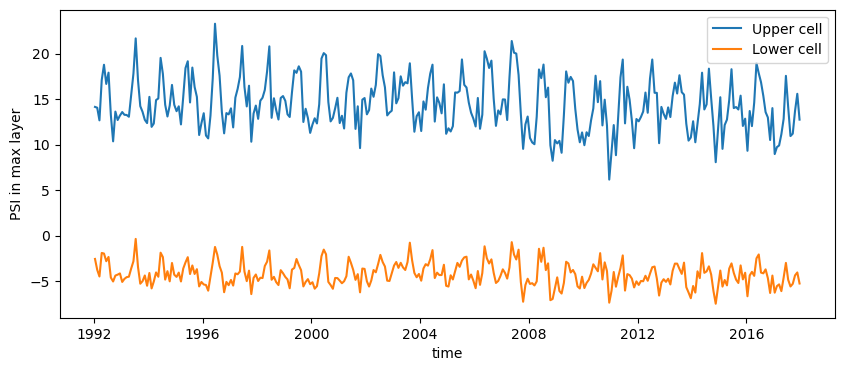

In [225]:
# Plot both streamfunctions for a sanity check
plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [226]:
def clip_dates(RAPID_inputs, inputs, full_outputs):

    # RAPID has the latest start date and the ECCO data has the earliest end date (combine)
    date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    #print('Date range to align to:', date_range)

    # Align the surface variable inputs with RAPID, then align the in- and outputs
    inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
    inputs, outputs = align_inputs_outputs(inputs, full_outputs, date_range = date_range, ecco=False)
    return inputs, RAPID_inputs, outputs

In [227]:
def preprocess_inputs(RAPID_inputs, inputs, psi_moc_variable):
    # Preprocess both surface variables as the RAPID input data
    pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

    # reshape as desired and convert to a numpy array
    pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=6, keep_coords=["time"], data_vars=[psi_moc_variable])
    pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=6, keep_coords=["time"], data_vars=["OBP", "ZWS"]) #keep longitude for training special 

    # Concatenate the different information layers together
    pp_data_np = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)
    #pp_data_np = pp_data_SURFACE_np
    #X_extra = pp_data_RAPID_np
    return pp_data_np

In [228]:
def preprocess_outputs(outputs, X):
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    
    # Necessary step to do convolutions along the right axis with pytorch tensors!
    dims = list(range(X.ndim))  
    dims[1], dims[-1] = dims[-1], dims[1]
    X = np.transpose(X, dims)

    conv_dims = 1
    if len(X.shape) == (conv_dims + 1):
        X = np.expand_dims(X, axis=-1)

    y = strength_np[-X.shape[0]:]
    
    """
    print()
    print('Inputs shape:', X.shape)
    print('Extra inputs shape:', X_extra.shape)
    print('Outputs shape:', y.shape)
    """
    return y

In [229]:
def define_train_and_validation_sets(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"

    Xt_train = t.tensor(X_train, device=device).double()
    Yt_train = t.tensor(y_train, device=device).double()
    Xt_valid = t.tensor(X_valid, device=device).double()
    Yt_valid = t.tensor(y_valid, device=device).double()
    Xt_test = t.tensor(X_test, device=device).double()
    Yt_test = t.tensor(y_test, device=device).double()
    return Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test

In [171]:
# Needed for the custom training with RAPID
X_train_extra, X_test_extra, y_extra, _ = train_test_split(X_extra, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train_extra, X_valid_extra, _, _ = train_test_split(X_train_extra, y_extra, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train_extra = t.tensor(X_train_extra, device=device).double()
Xt_valid_extra = t.tensor(X_valid_extra, device=device).double()
Xt_test_extra = t.tensor(X_test_extra, device=device).double()

Xt_train = Xt_train, Xt_train_extra
Xt_valid = Xt_valid, Xt_valid_extra
Xt_test  = Xt_test, Xt_test_extra

device: cpu


In [230]:
from models import CNN_RAPID, CNN1D, train_alt
importlib.reload(CNN_RAPID)
importlib.reload(train_alt)

<module 'models.train_alt' from 'C:\\Users\\aline\\OTP\\models\\train_alt.py'>

In [231]:
def get_input(lag_index, RAPID_all_inputs, inputs, cell='bottom'):

    # Decide which covariates and output to use 
    if cell == 'bottom':
        full_outputs = outputs_bottom_cell

    psi_moc_variable = f"psi_moc_lag{lag_index}"    #Can be normal 'psi_moc' or any other lag defined above
    RAPID_inputs = RAPID_all_inputs[[psi_moc_variable]]

    inputs, RAPID_inputs, outputs = clip_dates(RAPID_inputs, inputs, full_outputs)
    X = preprocess_inputs(RAPID_inputs, inputs, psi_moc_variable)
    y = preprocess_outputs(outputs, X)
    
    return define_train_and_validation_sets(X, y)

In [235]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 2
n_features = X.shape[1]
n_channels = n_features * 7
kernel_size = 3
model_iterations = 2
n_second_input_features = 2

def train_CNN(Xt_train, Yt_train):

    model = CNN1D.CNN1D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=Xt_train.shape[1], 
        n_channels=n_channels,
        kernel_size=kernel_size,
        dropout=dropout, 
        #n_second_input_features=n_second_input_features
    )

    model, train_loss = train_alt.train_model( #, val_loss
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        #X_val = Xt_valid,
        #y_val = Yt_valid, 
        #early_stopping=True,
        RAPID_dataset=False,
    )
    return model

models = []
for i in range(model_iterations):
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = get_input(i+1, RAPID_all_inputs, inputs)
    models.append(train_CNN(Xt_train, Yt_train))

axes: ['time', 'history', 'feature']
variables: ['psi_moc_lag1']
shape: (158, 6, 1)
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (158, 6, 2)
device: cpu
6637 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 160.78it/s]


axes: ['time', 'history', 'feature']
variables: ['psi_moc_lag2']
shape: (157, 6, 1)
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (157, 6, 2)
device: cpu
6637 parameters.


 27%|██▋       | 1361/5000 [00:08<00:21, 167.42it/s]


KeyboardInterrupt: 

In [192]:
importlib.reload(train_alt)
importlib.reload(CNN_RAPID)

<module 'models.CNN_RAPID' from 'C:\\Users\\aline\\OTP\\models\\CNN_RAPID.py'>

In [193]:
def predict_CNN(model):
    model =  model.double()

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train, RAPID_dataset=False)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid, RAPID_dataset=False)
    test_set_pred = train_alt.predict(model, Xt_test, Yt_test, RAPID_dataset=False)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test, threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        }
    
    return predictions, metrics

predictions_models = []
metrics_models = []

for i in range(len(models)):
    predictions, metrics = predict_CNN(models[i])
    predictions_models.append(predictions)
    metrics_models.append(metrics)

metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)

,mean,std
rmse,1.145,NaN
mae,0.954,NaN
mape,18.600,NaN
cmape,18.600,NaN
test_corr,0.442,NaN


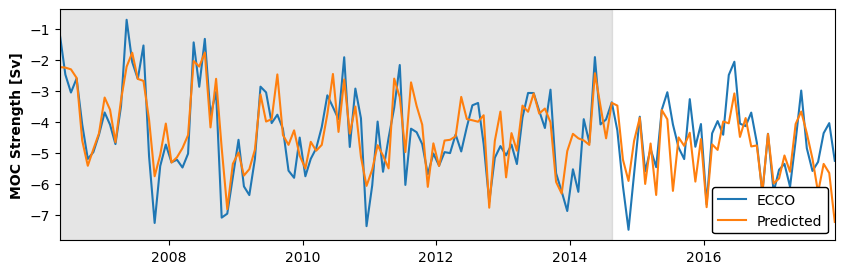

In [137]:
mean_arrays = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}
all_preds = mean_arrays['all_preds']
time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

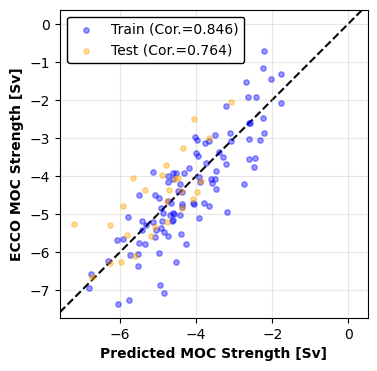

In [138]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_arrays['train_set_pred']).squeeze()
y_pred_test = np.array(mean_arrays['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()